In [1]:
%%bash
df -h .

Filesystem      Size  Used Avail Use% Mounted on
beegfs_nodev    175T  159T   16T  92% /mnt/pfs


In [2]:
import warnings

warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

import numpy as np

import gwpy

print(gwpy.__version__)

import matplotlib.pyplot as plt

3.0.8


In [3]:
%%bash
hostname

sonic13


In [4]:
from gwosc.datasets import event_gps

gps0 = event_gps("GW150914")
gps1 = event_gps("GW190412")
print(gps0, gps1)

1126259462.4 1239082262.1


In [5]:
segment0 = (int(gps0) - 8, int(gps0) + 8)

In [6]:
segment1 = (int(gps0) + 8, int(gps0) + 26)

In [7]:
print(segment0, segment1)

(1126259454, 1126259470) (1126259470, 1126259488)


In [8]:
from gwpy.timeseries import TimeSeries

# ldata0 = TimeSeries.fetch_open_data('L1', *segment0, verbose=True)
ldata0f = TimeSeries.read("GW150914_16s.txt")

In [9]:
# ldata0.write("GW150914_16s.txt")

In [10]:
# ldata1 = TimeSeries.fetch_open_data('L1', *segment1, verbose=True)
ldata1f = TimeSeries.read("GW150914_af_16s.txt")

In [14]:
N0 = len(ldata0)
N1 = len(ldata1)

N0, N1

NameError: name 'ldata0' is not defined

In [15]:
N0 / 16

NameError: name 'N0' is not defined

In [16]:
N1 / 18

NameError: name 'N1' is not defined

In [12]:
sf = 4096

In [13]:
ldata0 = ldata0f[6 * sf : -6 * sf]

In [14]:
ldata1 = ldata1f[6 * sf : -8 * sf]

In [15]:
print(ldata0, ldata1)

TimeSeries([-9.94811209e-19, -9.51210341e-19, -9.17031777e-19,
            ..., -9.58747737e-19, -9.88194152e-19,
            -9.98132251e-19]
           unit: dimensionless,
           t0: 1126259460.0 s,
           dt: 0.000244140625 s,
           name: None,
           channel: None) TimeSeries([-6.57136184e-19, -6.56001090e-19, -6.96092409e-19,
            ..., -1.00169963e-18, -1.01950937e-18,
            -1.01734639e-18]
           unit: dimensionless,
           t0: 1126259476.0 s,
           dt: 0.000244140625 s,
           name: None,
           channel: None)


In [16]:
# ldata1.write("GW150914_af_16s.txt")

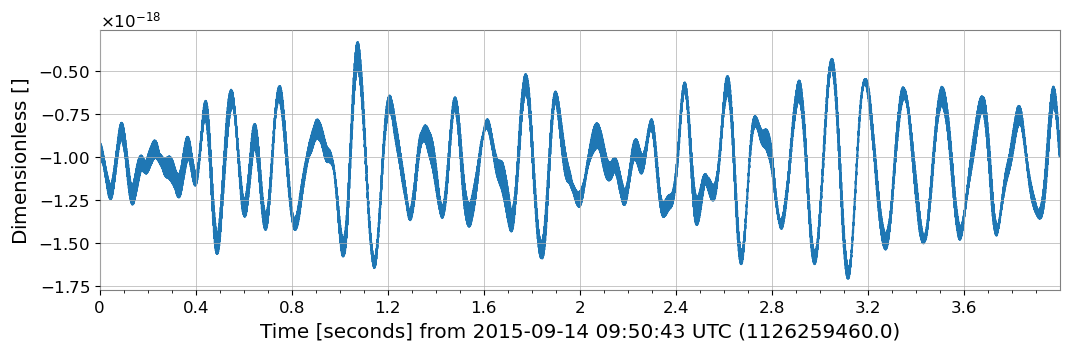

In [17]:
plot0 = ldata0.plot()

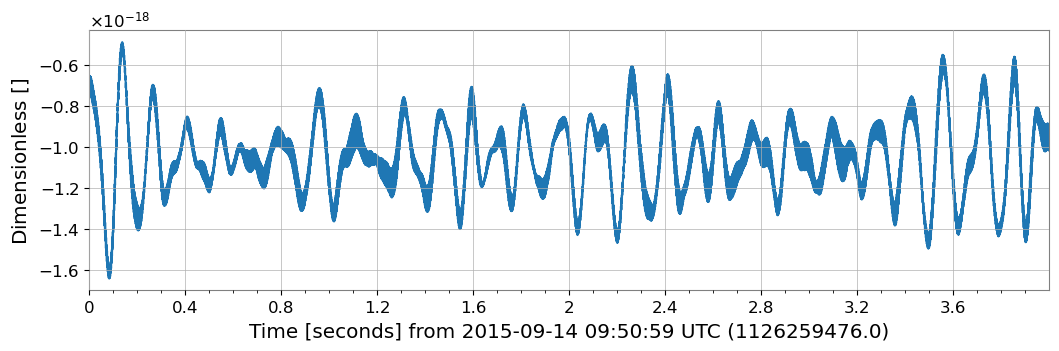

In [18]:
plot1 = ldata1.plot()

In [19]:
from waveformtools.waveformtools import roll

/mnt/pfs/vaishak.p/Projects/Codes/custom_libraries/waveformtools/waveformtools
No module named 'pycbc'


In [20]:
len(ldata0), len(ldata1)

(16384, 16384)

In [21]:
def auto_coorelate(ts):
    """Autocorrelate a astretch of data"""

    N = len(ts)

    autocorr = []

    for index in range(0, N):

        # print(index/N)
        ts2 = roll(np.array(ts), index)

        autocorr.append(np.dot(np.array(ts), np.array(ts2)))

        # if index%100==0:
        #    g = input("Continue?")

    return autocorr

In [22]:
acorr = auto_coorelate(ldata1)

In [23]:
%%bash
lscpu

Architecture:                    x86_64
CPU op-mode(s):                  32-bit, 64-bit
Address sizes:                   43 bits physical, 48 bits virtual
Byte Order:                      Little Endian
CPU(s):                          96
On-line CPU(s) list:             0-95
Vendor ID:                       AuthenticAMD
Model name:                      AMD EPYC 7352 24-Core Processor
CPU family:                      23
Model:                           49
Thread(s) per core:              2
Core(s) per socket:              24
Socket(s):                       2
Stepping:                        0
BogoMIPS:                        4591.17
Flags:                           fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ht syscall nx mmxext fxsr_opt pdpe1gb rdtscp lm constant_tsc rep_good nopl nonstop_tsc cpuid extd_apicid aperfmperf rapl pni pclmulqdq monitor ssse3 fma cx16 sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand lahf_lm cm

In [24]:
%%bash
free -h

               total        used        free      shared  buff/cache   available
Mem:           250Gi        40Gi       209Gi        51Mi       3.1Gi       210Gi
Swap:           63Gi          0B        63Gi


In [25]:
Cij_comp_cache = {}


def get_symm_toeplez_Cij(i, j):
    """Autocorrelate a a stretch of data"""

    rho_ind = abs(i - j)

    if rho_ind in Cij_comp_cache.keys():
        Cij_element = Cij_comp_cache[rho_ind]

    else:
        Cij_element = acorr[rho_ind]
        Cij_comp_cache.update({rho_ind: Cij_element})

    return Cij_element

In [26]:
from waveformtools.waveformtools import progressbar

In [27]:
N = len(ldata1)

In [28]:
tc = N * (N + 1) / 2

In [29]:
tc

134225920.0

In [30]:
10000 / tc

7.450125877326823e-05

In [31]:
100000 / tc

0.0007450125877326824

In [32]:
N = len(ldata1)

In [33]:
N

16384

In [34]:
Cij = np.zeros((N, N))

count = 0
tcounts = N * (N + 1) / 2

M = N
for row_ind in range(M):
    for col_ind in range(row_ind, M):

        Cij[row_ind, col_ind] = acorr[abs(col_ind - row_ind)]

        if row_ind != col_ind:
            Cij[col_ind, row_ind] = Cij[row_ind, col_ind]

        count += 1

        if count % 10000 == 0:
            progressbar(count, tcounts)

        # print(count/tcounts, "\n")

Progress:|0                                                                                                  |0%

Progress:|#################################################################################################9 |100%

In [35]:
Cij

array([[1.86124320e-32, 1.86063771e-32, 1.85949414e-32, ...,
        1.85877604e-32, 1.85949414e-32, 1.86063771e-32],
       [1.86063771e-32, 1.86124320e-32, 1.86063771e-32, ...,
        1.85859378e-32, 1.85877604e-32, 1.85949414e-32],
       [1.85949414e-32, 1.86063771e-32, 1.86124320e-32, ...,
        1.85874069e-32, 1.85859378e-32, 1.85877604e-32],
       ...,
       [1.85877604e-32, 1.85859378e-32, 1.85874069e-32, ...,
        1.86124320e-32, 1.86063771e-32, 1.85949414e-32],
       [1.85949414e-32, 1.85877604e-32, 1.85859378e-32, ...,
        1.86063771e-32, 1.86124320e-32, 1.86063771e-32],
       [1.86063771e-32, 1.85949414e-32, 1.85877604e-32, ...,
        1.85949414e-32, 1.86063771e-32, 1.86124320e-32]])

In [37]:
np.save("/home/vaishakprasad/Cij_matrix_4s.obj", Cij)

In [ ]:
from waveformtools.waveformtools import progressbar

In [ ]:
def compute_Cij(N):

    count = 0
    tcounts = N * (N + 1) / 2

    Cij = np.zeros((N, N))
    for row_ind in range(N):
        for col_ind in range(row_ind, N):

            Cij[row_ind, col_ind] = get_symm_toeplez_Cij(row_ind, col_ind)

            if row_ind != col_ind:
                Cij[col_ind, row_ind] = Cij[row_ind, col_ind]

            count += 1

            if count % 100000 == 0:
                print(count, "\n")
            progressbar(count, tcounts)

    return Cij

In [ ]:
def compute_Cij_no_assumptions(ts):
    """Autocorrelate a astretch of data"""

    N = len(ts)

    Cij = np.zeros((N, N))

    flag_arr = np.zeros(Cij.shape)

    ts0 = np.array(ts)

    count = 0
    for index_i in range(N):
        for index_j in range(index_i, N):
            count += 1
            if count % 10000 == 0:
                print(2 * count / (N**2 - N))
            flag = bool(flag_arr[index_i, index_j])

            if not flag:
                # print(index/N)
                ts1 = roll(ts0, index_i)
                ts2 = roll(ts0, index_j)

                # Cij[index_i, index_j] = np.dot(np.array(ts1), np.array(ts2))
                Cij[index_i, index_j] = np.correlate(ts1, ts2)
                flag_arr[index_i, index_j] = 1

                if index_i != index_j:
                    Cij[index_j, index_i] = Cij[index_i, index_j]
                    flag_arr[index_j, index_j] = 1
            # if index%100==0:
            #    g = input("Continue?")

    return Cij

In [ ]:
# acorr = auto_coorelate(ldata1)

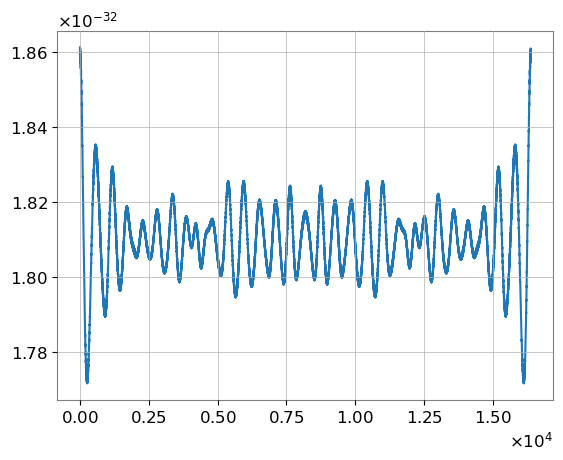

In [36]:
plt.plot(acorr)

In [37]:
acorr

[1.8612432047465852e-32,
 1.86063771266202e-32,
 1.8594941438294493e-32,
 1.8587760353448212e-32,
 1.8585937785008077e-32,
 1.85874069452799e-32,
 1.8593830091758855e-32,
 1.8604313735444095e-32,
 1.860967701760621e-32,
 1.8603102472148086e-32,
 1.859086018780239e-32,
 1.8582978936894833e-32,
 1.858086841460554e-32,
 1.8582047973224606e-32,
 1.858776971474028e-32,
 1.859733999876441e-32,
 1.8602075729663985e-32,
 1.859501802360336e-32,
 1.858203027172687e-32,
 1.8573465198011082e-32,
 1.8571064785258723e-32,
 1.8571975453089805e-32,
 1.8577008714161996e-32,
 1.8585642866816095e-32,
 1.8589719573895612e-32,
 1.8582221076792272e-32,
 1.8568573301700947e-32,
 1.8559348966913543e-32,
 1.855666510736009e-32,
 1.8557329380968168e-32,
 1.8561687830554458e-32,
 1.8569370973888616e-32,
 1.857275447858029e-32,
 1.8564856295102267e-32,
 1.8550643443404623e-32,
 1.85407980863617e-32,
 1.8537847922535498e-32,
 1.8538304889988735e-32,
 1.854201748012682e-32,
 1.8548749882410832e-32,
 1.8551419905486

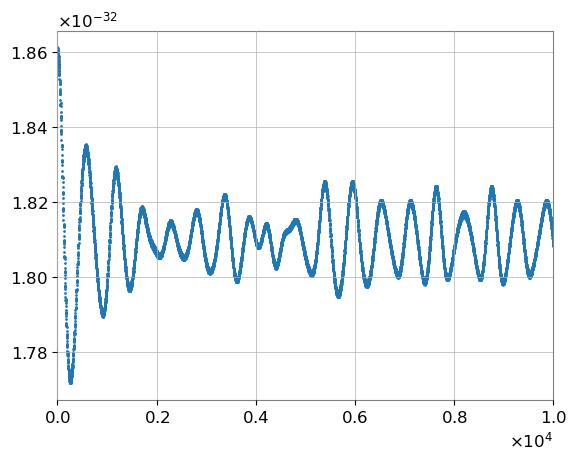

In [38]:
plt.scatter(np.arange(len(acorr)), acorr, s=1)
plt.xlim(0, 10000)
plt.show()

# Inject a damped sinusoid in the noise

In [39]:
time_axis = np.array(ldata1.times)

In [ ]:
import qnm

qnm.download_data()

Destination path /home/vaishak.p/.cache/qnm/data-0.4.0.tar.bz2 already exists, use overwrite=True to force an overwrite.


In [ ]:
grav_220 = qnm.modes_cache(s=-2, l=2, m=2, n=0)
omega_inj, _, _ = grav_220(a=0.68)
print(omega_inj)

(0.523975104290084-0.08151262363119886j)


In [ ]:
import units

ModuleNotFoundError: No module named 'units'

In [ ]:
Msun = 2 * 1e30
G = 6.6743 * 1e-11
c = 2.99792458 * 1e8
Mevent = 62

Tc = G * Msun * Mevent / (c**3)

In [ ]:
Tc

0.0003071604534396641

In [ ]:
omega / Tc

(1705.8677262078243-265.3747340140924j)

In [ ]:
omega_inj_SI = omega_inj / Tc
f_SI = omega_inj_SI / (2 * np.pi)
print(omega_inj_SI, f_SI)

(1705.8677262078243-265.3747340140924j) (271.49728088690716-42.235700690039735j)


In [ ]:
1 / 42

0.023809523809523808

In [85]:
t0 - gps0

13.599999904632568

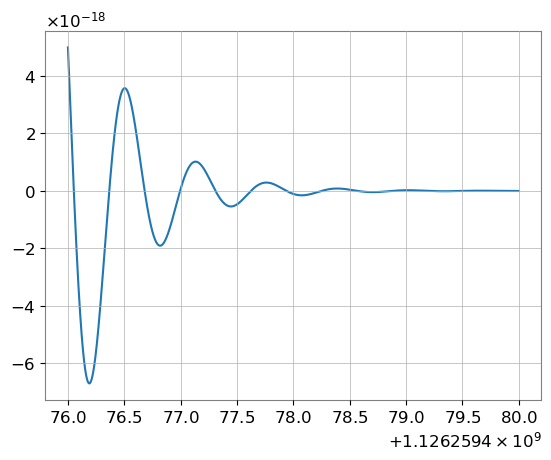

In [40]:
omega0 = 10
gamma0 = 2
phi0 = np.pi / 3
A0 = 1e-17

time_axis = np.array(ldata1.times)
t0 = time_axis[0]

signal = (
    A0 * np.cos(omega0 * (time_axis - t0) + phi0) * np.exp(-gamma0 * (time_axis - t0))
)

plt.plot(time_axis, signal)

plt.show()

In [ ]:
# noise = 1e-2*np.random.randn(len(ldata1))

In [41]:
noise = np.array(ldata1)

data = noise + signal

data0 = gwpy.timeseries.TimeSeries(data=data, times=time_axis)

In [42]:
noise

array([-6.57136184e-19, -6.56001090e-19, -6.96092409e-19, ...,
       -1.00169963e-18, -1.01950937e-18, -1.01734639e-18])

In [43]:
data

array([ 4.34286382e-18,  4.32041035e-18,  4.25672266e-18, ...,
       -1.00499276e-18, -1.02279926e-18, -1.02063303e-18])

In [44]:
ldata0.times[0]

<Quantity 1.12625946e+09 s>

In [ ]:
time_axis[0]

1126259474.0

In [ ]:
data0.plot()

NameError: name 'data0' is not defined

In [ ]:
def DiagCijFromRho(rho):

    return np.diag(rho)

In [ ]:
# acorr = auto_coorelate(noise)

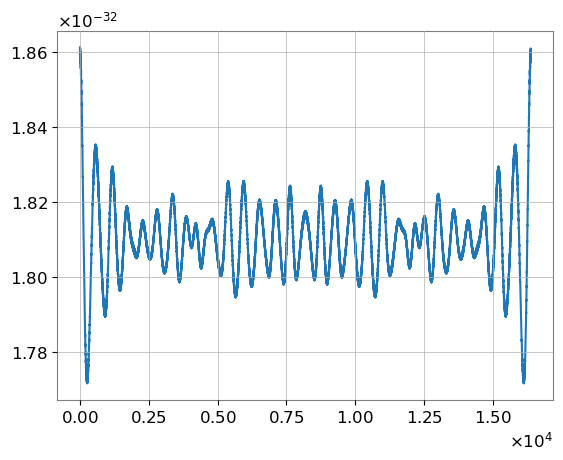

In [ ]:
plt.plot(acorr)

In [ ]:
tc

134225920.0

In [ ]:
N * (N + 1) / 2

536887296.0

In [ ]:
100000 / tc

In [ ]:
0.01 * tc

27179458.560000002

In [46]:
Cij[-1, :]

array([1.86063771e-32, 1.85949414e-32, 1.85877604e-32, ...,
       1.85949414e-32, 1.86063771e-32, 1.86124320e-32])

In [48]:
Cij[:, -1]

array([1.86063771e-32, 1.85949414e-32, 1.85877604e-32, ...,
       1.85949414e-32, 1.86063771e-32, 1.86124320e-32])

In [44]:
dc = np.linalg.det(Cij)

In [45]:
dc

0.0

In [45]:
inv_Cij = np.linalg.inv(Cij)

In [51]:
inv_Cij @ Cij

array([[ 1.00006361e+00,  6.35510369e-05,  6.35057222e-05, ...,
         6.35800825e-05,  6.36247860e-05,  6.36459445e-05],
       [-1.75481186e-04,  9.99824681e-01, -1.75202975e-04, ...,
        -1.75405945e-04, -1.75519188e-04, -1.75562614e-04],
       [ 1.57951611e-04,  1.57804160e-04,  1.00015770e+00, ...,
         1.57907562e-04,  1.58005136e-04,  1.58032098e-04],
       ...,
       [ 1.40440534e-07,  1.40112206e-07,  1.40412340e-07, ...,
         1.00000014e+00,  1.39191343e-07,  1.42170848e-07],
       [ 9.25865606e-09,  9.29503585e-09,  8.88394425e-09, ...,
         8.45466275e-09,  1.00000001e+00,  1.02736522e-08],
       [-1.50408596e-07, -1.50670530e-07, -1.50495907e-07, ...,
        -1.49448169e-07, -1.52009306e-07,  9.99999846e-01]])

In [46]:
from scipy.interpolate import interp1d

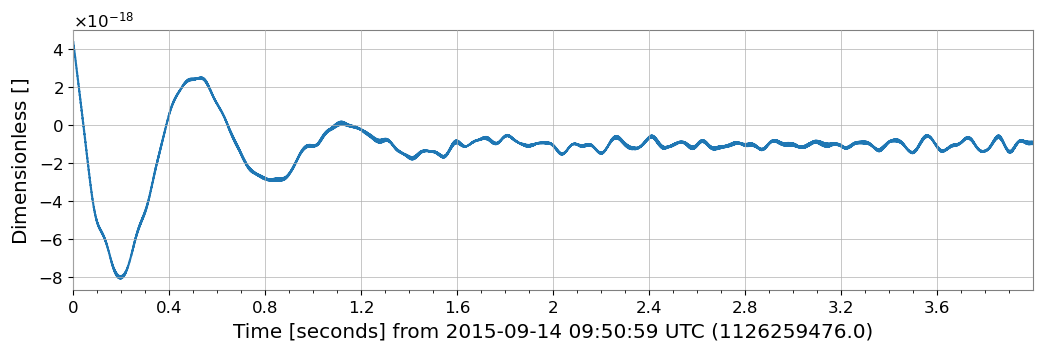

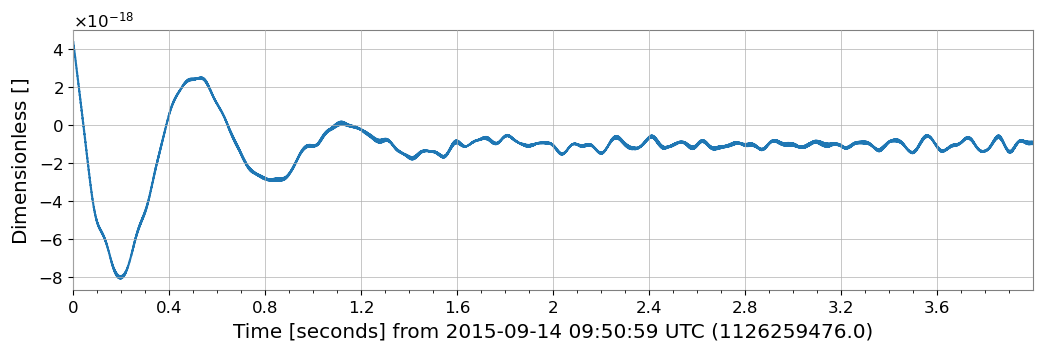

In [48]:
data0.plot()

In [49]:
inv_Cij

array([[ 2.81539178e+37, -1.57586927e+37,  1.44376197e+36, ...,
         4.38756948e+36,  1.44376370e+36, -1.57586941e+37],
       [-1.57586930e+37,  2.81539170e+37, -1.57586928e+37, ...,
        -7.55962459e+36,  4.38756940e+36,  1.44376297e+36],
       [ 1.44376212e+36, -1.57586928e+37,  2.81539175e+37, ...,
         6.18393303e+36, -7.55962505e+36,  4.38757037e+36],
       ...,
       [ 4.38756958e+36, -7.55962460e+36,  6.18393306e+36, ...,
         2.81539169e+37, -1.57586928e+37,  1.44376272e+36],
       [ 1.44376332e+36,  4.38756988e+36, -7.55962542e+36, ...,
        -1.57586930e+37,  2.81539178e+37, -1.57586939e+37],
       [-1.57586937e+37,  1.44376239e+36,  4.38757078e+36, ...,
         1.44376303e+36, -1.57586941e+37,  2.81539186e+37]])

In [116]:
def TimeDomainLogLiklihood(x):

    # A, omega, gamma, t0, phi0 = x
    # A, omega, gamma, phi = x
    # omega, gamma, t = x
    A, omega, gamma, phi = x
    t = t0
    # print(f"A {A}, omega {omega}, gamma {gamma}, t0 {t0}, phi0 {phi0}")
    tloc = np.argmin(abs(time_axis - t))

    s = A0 * np.cos(omega * (time_axis - t) + phi0) * np.exp(-gamma * (time_axis - t))

    s[:tloc] = 0

    # print(tloc)
    # print(s[:tloc+10], tloc)

    LnP = (-1 / 2) * (np.dot((data - s), np.dot(inv_Cij, (data - s))))
    return LnP

In [ ]:
TimeDomainLogLiklihood([1])

ValueError: not enough values to unpack (expected 2, got 1)

In [ ]:
TimeDomainLogLiklihood([1, 100, 100, 0])

-1.045857623243356e+32

In [ ]:
time_axis[0]

1126259454.0

In [ ]:
TimeDomainLogLiklihood(0)

TypeError: cannot unpack non-iterable int object

In [ ]:
gps0

1126259462.4

In [ ]:
gps0

1126259462.4

In [117]:
A0

1e-17

In [118]:
import numpy as np

# Define the dimensionality of our problem.
ndim = 4

# Define our 3-D correlated multivariate normal log-likelihood.
# C = np.identity(ndim)

# lnorm = -0.5 * (np.log(2 * np.pi) * ndim +
#                np.log(np.linalg.det(Cij)))


# Define our uniform prior via the prior transform.
def ptform_omega(u):
    return 5 + u * 10


def ptform_gamma(u):
    return 1 + u * 2


def ptform(u):

    x = np.array(u)

    x[0] = u[0] * 1e-16
    x[1] = 4 + u[0] * 8
    x[2] = u[1] * 8

    # x[1] = u[1]*25

    # x[2] = 10 + u[2]*200
    # x[2] = u[2]*20
    # x[2] = gps0 +12 + u[2]*6
    # x[3] = gps0 + 0.1 - 8 + u[3]*7
    x[3] = -np.pi + u[3] * np.pi

    return x

In [87]:
t0 - gps0

13.599999904632568

In [52]:
omega0, gamma0, t0

(10, 2, 1126259476.0)

In [53]:
from dynesty import NestedSampler

In [137]:
sampler = NestedSampler(TimeDomainLogLiklihood, ptform, ndim, nlive=2000)

In [138]:
sampler.run_nested()

7423it [25:56,  4.77it/s, +2000 | bound: 1 | nc: 1 | ncall: 75450 | eff(%): 12.829 | loglstar:   -inf < -0.500 <    inf | logz: -4.655 +/-  0.047 | dlogz:  0.001 >  2.009]


In [54]:
import dynesty

In [55]:
from dynesty import DynamicNestedSampler

In [56]:
dsampler = dynesty.DynamicNestedSampler(
    TimeDomainLogLiklihood, prior_transform=ptform, ndim=ndim
)

In [ ]:
dsampler = DynamicNestedSampler.restore("5param_28Apr_GW150914_5.h5")

In [ ]:
dsampler.run_nested(checkpoint_file="1param_inj_30_apr_1.h5")

539it [04:27,  2.18it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 986 | eff(%): 36.272 | loglstar:   -inf < -0.523 <    inf | logz: -0.944 +/-  0.029 | dlogz:  0.419 >  0.010] Traceback (most recent call last):
  File "/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gwpy/lib/python3.12/site-packages/dynesty/dynesty.py", line 910, in __call__
    return self.func(np.asarray(x).copy(), *self.args, **self.kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/tmp/ipykernel_927113/3875626261.py", line 17, in TimeDomainLogLiklihood
    LnP = (-1/2) * np.dot((data-s), np.dot(inv_Cij, (data-s)))
                                    ^^^^^^^^^^^^^^^^^^^^^^^^^
KeyboardInterrupt
539it [04:28,  2.01it/s, batch: 0 | bound: 0 | nc: 4 | ncall: 986 | eff(%): 36.272 | loglstar:   -inf < -0.523 <    inf | logz: -0.944 +/-  0.029 | dlogz:  0.419 >  0.010]

Exception while calling loglikelihood function:
  params: [9.2639799]
  args: []
  kwargs: {}
  exception:


KeyboardInterrupt: 

In [ ]:
dsampler.run_nested(resume=True)

/mnt/pfs/vaishak.p/soft/anaconda3_2023/envs/gwpy/lib/python3.12/site-packages/dynesty/dynamicsampler.py:2034: RuntimeWarning: You tried to resume the run that has ended successfully.
This is not supported. No sampling was performed
  warnings.warn(


In [133]:
res = sampler.results
results = res

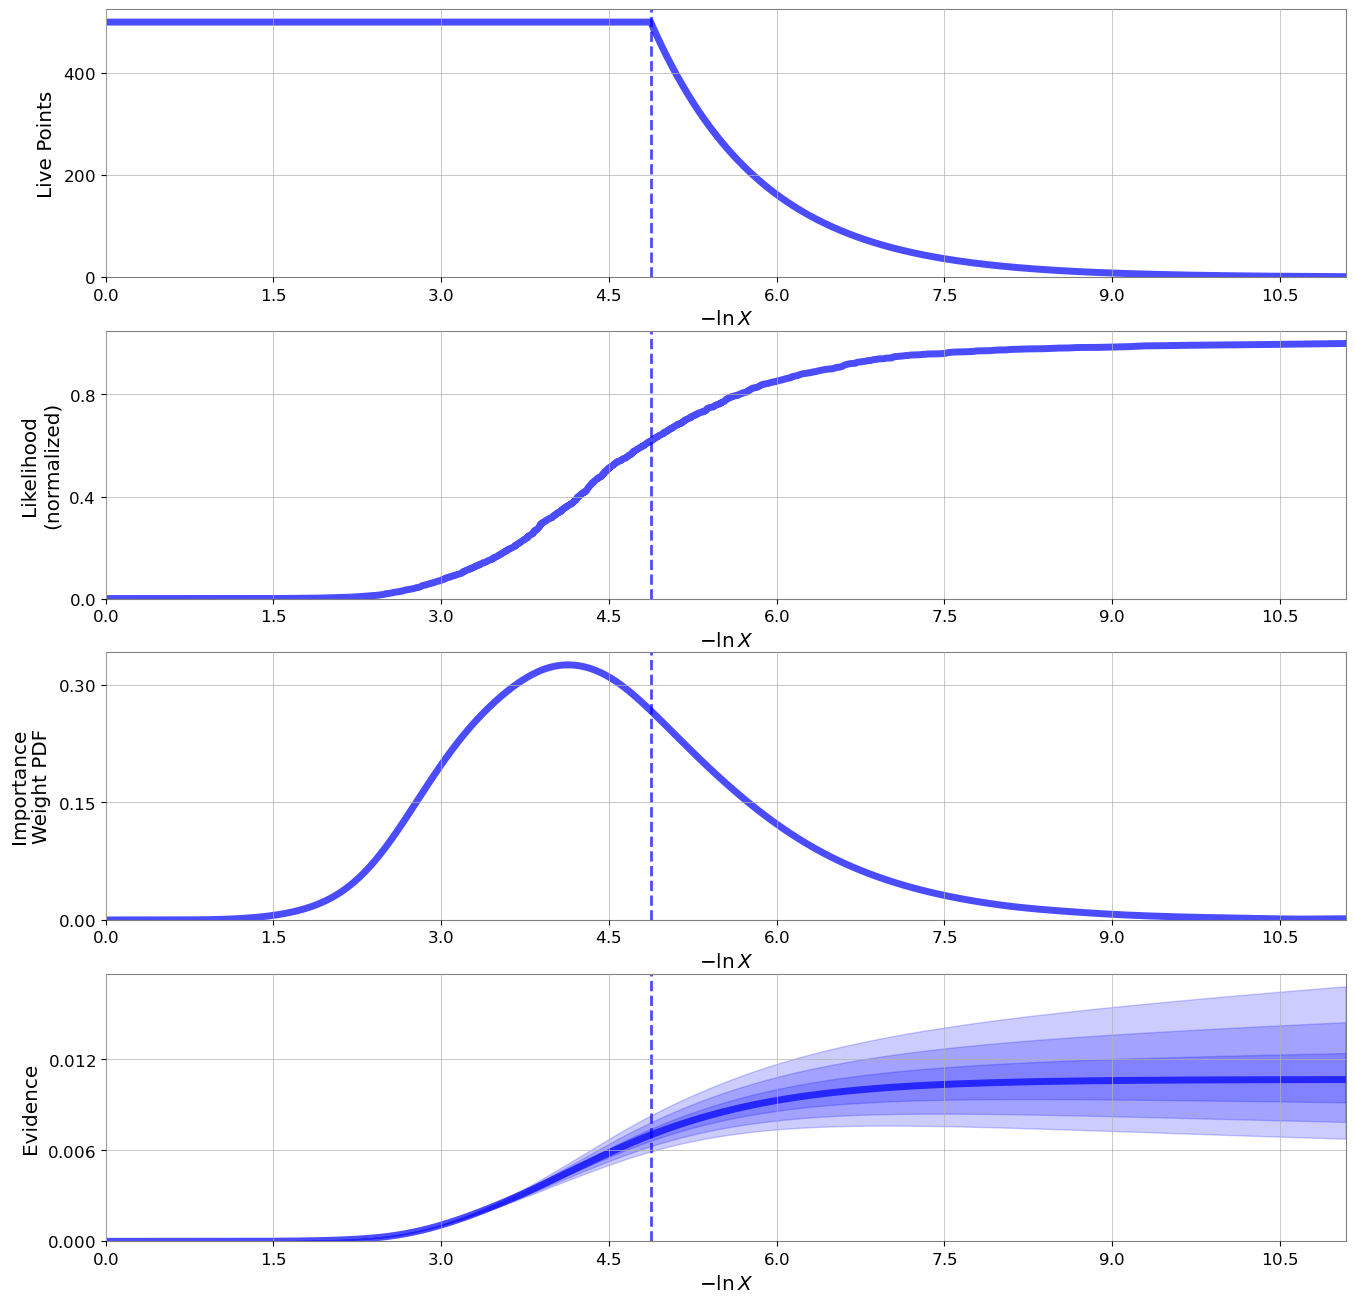

In [134]:
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(res)

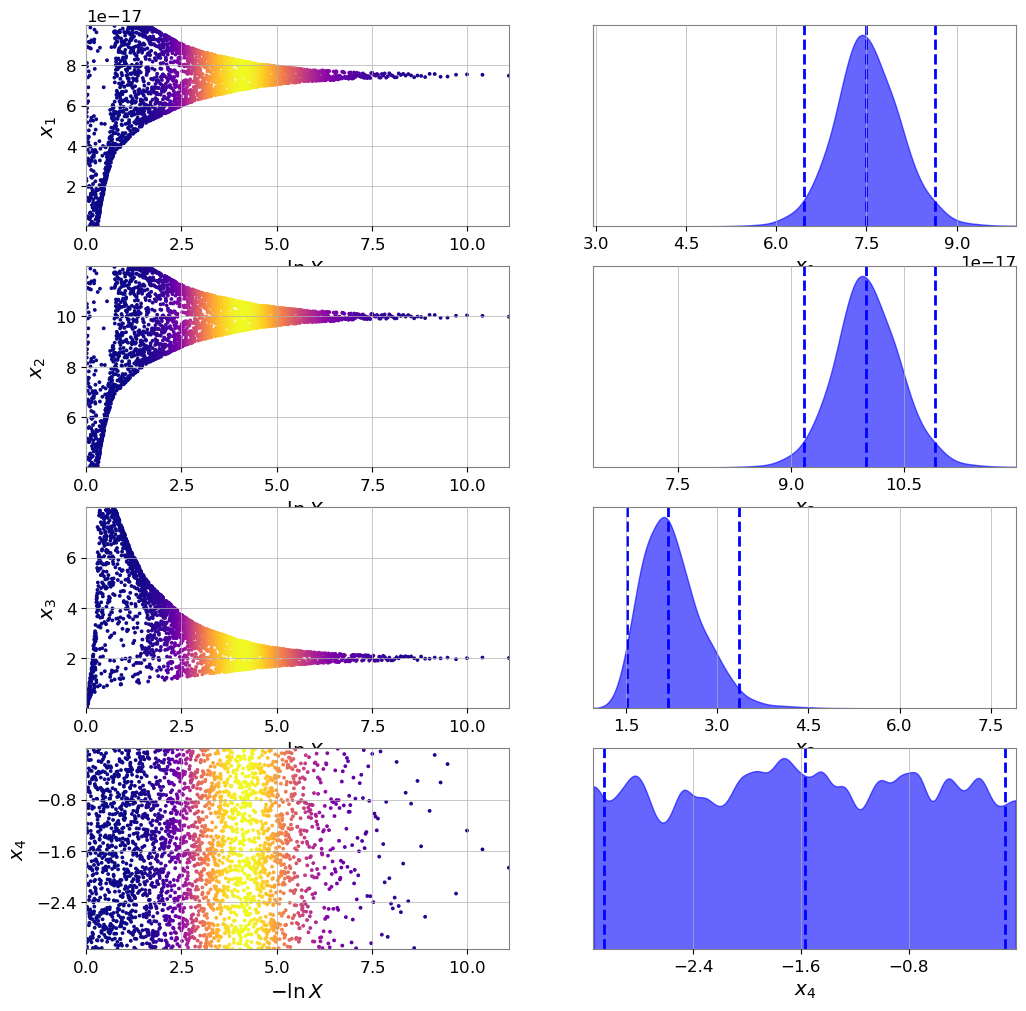

In [135]:
# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(res)

In [68]:
t0

1126259476.0

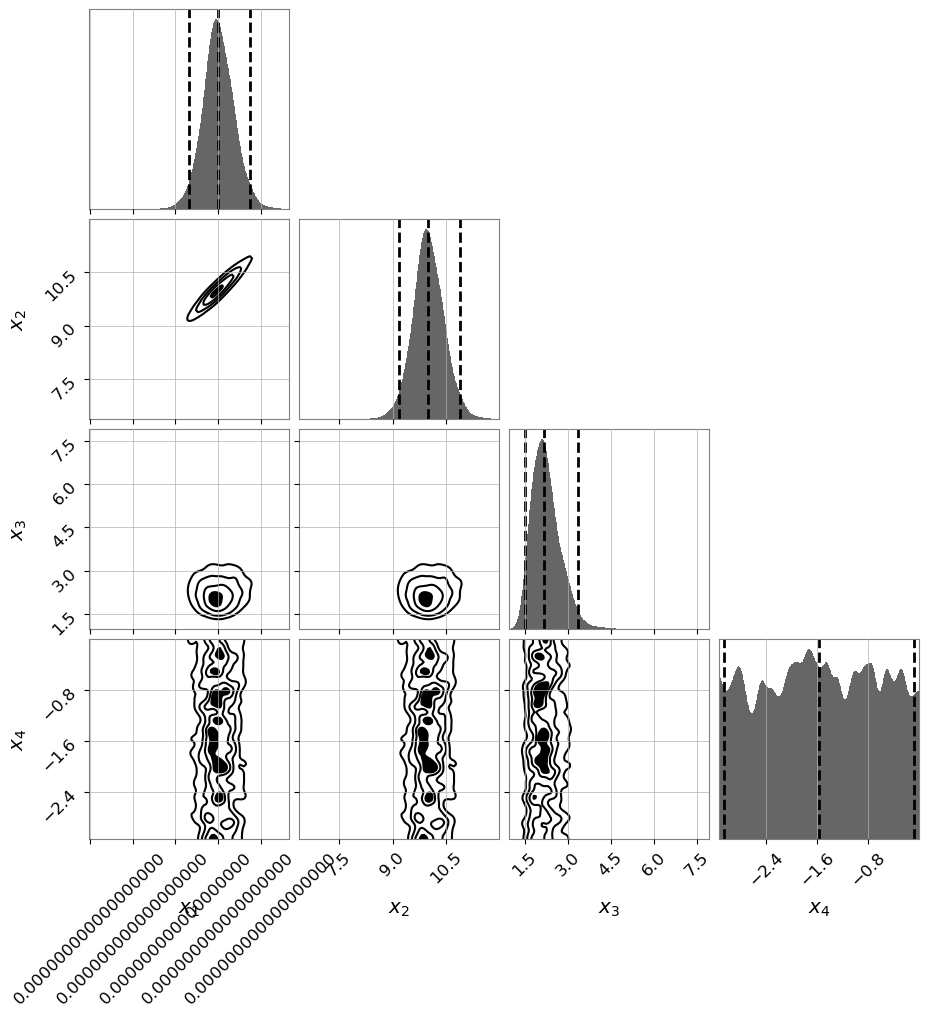

In [136]:
# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(res)

In [70]:
omega0, gamma0

(10, 2)

In [125]:
from dynesty import utils as dyfunc

# Extract sampling results.
samples = results.samples  # samples
weights = results.importance_weights()

# Compute 10%-90% quantiles.
quantiles = [dyfunc.quantile(samps, [0.1, 0.9], weights=weights) for samps in samples.T]

# Compute weighted mean and covariance.
mean, cov = dyfunc.mean_and_cov(samples, weights)

# Resample weighted samples.
samples_equal = results.samples_equal()

# Generate a new set of results with sampling uncertainties.
results_sim = dyfunc.resample_run(results)

In [126]:
import scipy

In [127]:
np.mean(samples.T * weights)

0.001950051832746425

In [128]:
t0

1126259476.0

In [129]:
mean

array([ 7.47632097e-17,  9.98105678e+00,  2.27031489e+00,
       -1.58068804e+00])

In [130]:
phi0

1.0471975511965976

In [115]:
mean[2] - t0

-0.005499124526977539

In [82]:
cov

array([[ 6.37586194e-01,  9.54344501e-05, -6.51571787e-01],
       [ 9.54344501e-05,  5.95067795e-04,  5.94574088e-01],
       [-6.51571787e-01,  5.94574088e-01,  8.11360986e+02]])

In [83]:
t0 - 1.12625940e09

76.0

In [ ]:
A

1e-18

In [ ]:
phi0

1.0471975511965976

In [ ]:
-1.58880414e00

-1.58880414

In [ ]:
s0 = A * np.cos(omega * (time_axis - t0) + phi0) * np.exp(-gamma * (time_axis - t0))

In [ ]:
A1, omega1, gamma1, t1, phi1 = mean

In [ ]:
s0 = A * np.cos(omega * (time_axis - t0) + phi0) * np.exp(-gamma * (time_axis - t0))

In [ ]:
s1 = A1 * np.cos(omega1 * (time_axis - t1) + phi1) * np.exp(-gamma1 * (time_axis - t1))

In [ ]:
s1 = A1 * np.cos(omega1 * (time_axis - t0) + phi1) * np.exp(-gamma1 * (time_axis - t0))

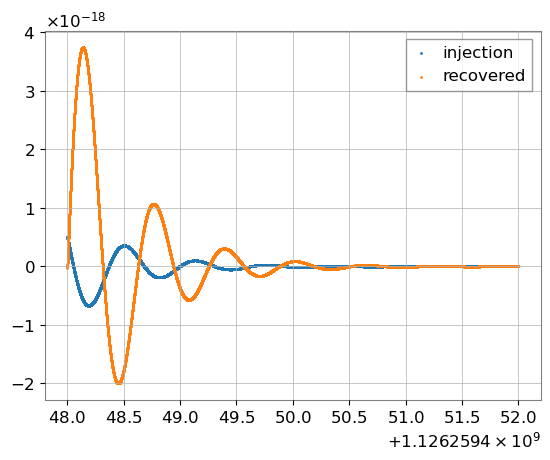

In [ ]:
plt.scatter(time_axis, s0, label="injection", s=1)
plt.scatter(time_axis, s1, label="recovered", s=1)
plt.legend()
plt.show()